In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def query_postgresql_table(db_name, schema_name, table_name, user, password, host='localhost', port=5432):
    """
    Conecta a una base de datos PostgreSQL usando SQLAlchemy y retorna los datos de una tabla como un DataFrame.
    
    Args:
        db_name (str): Nombre de la base de datos.
        schema_name (str): Nombre del esquema.
        table_name (str): Nombre de la tabla.
        user (str): Usuario de la base de datos.
        password (str): Contraseña del usuario.
        host (str): Host de la base de datos. Por defecto, 'localhost'.
        port (int): Puerto de conexión. Por defecto, 5432.
        
    Returns:
        pd.DataFrame: Datos de la tabla en un DataFrame de pandas.
    """
    # Crear la cadena de conexión
    connection_string = f"postgresql://{user}:{password}@{host}:{port}/{db_name}"
    
    # Crear el motor de conexión
    engine = create_engine(connection_string)
    
    # Leer los datos con pandas
    query = f"SELECT * FROM {schema_name}.{table_name}"
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    
    return df

In [3]:
# Parámetros de conexión
db_name = 'mdi_dwh'
schema_name = 'data_lake'
table_name = 'hi_historico_da'
user = 'postgres'
password = 'marce'

# Llamar a la función
df_hi_2024 = query_postgresql_table(db_name, schema_name, table_name, user, password)

# Asegúrate de que las columnas necesarias existen y están en el formato correcto
df_hi_2024['fecha_infraccion'] = pd.to_datetime(df_hi_2024['fecha_infraccion'], errors='coerce')
df_hi_2024['mes_infraccion'] = df_hi_2024['fecha_infraccion'].dt.month
df_hi_2024['anio_infraccion'] = df_hi_2024['fecha_infraccion'].dt.year

# Crear una columna codificada para los nombres de los meses
df_hi_2024['nombre_mes_infraccion'] = df_hi_2024['mes_infraccion'].map({
    1: 'Enero', 
    2: 'Febrero',
    3: 'Marzo', 
    4: 'Abril', 
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio', 
    8: 'Agosto',
    9: 'Septiembre', 
    10: 'Octubre',
    11: 'Noviembre', 
    12: 'Diciembre'
})

# Agrupar por provincia, año y nombre del mes
reporte = (
    df_hi_2024
    .groupby(['provincia', 'anio_infraccion', 'nombre_mes_infraccion'])
    .size()  # Contar los registros
    .reset_index(name='conteo_casos')  # Renombrar la columna del conteo
)

# Ordenar el reporte por provincia, año y mes
reporte['mes_orden'] = reporte['nombre_mes_infraccion'].map({
    'Enero': 1,
    'Febrero': 2,
    'Marzo': 3, 
    'Abril': 4,
    'Mayo': 5, 
    'Junio': 6,
    'Julio': 7,
    'Agosto': 8, 
    'Septiembre': 9, 
    'Octubre': 10,
    'Noviembre': 11, 
    'Diciembre': 12
})
reporte = reporte.sort_values(by=['provincia', 'anio_infraccion', 'mes_orden'])
reporte = reporte.drop(columns=['mes_orden'])  # Eliminar columna auxiliar

In [4]:
df_hi_2024.dtypes

tipo_muerte                         object
zona                                object
subzona                             object
distrito                            object
circuito                            object
codigo_subcircuito                  object
subcircuito                         object
provincia                           object
codigo_provincia                     int64
canton                              object
codigo_canton                       object
latitud                            float64
longitud                           float64
area_hecho                          object
lugar                               object
tipo_lugar                          object
fecha_infraccion            datetime64[ns]
hora_infraccion                     object
arma                                object
tipo_arma                           object
presunta_motivacion                 object
presun_motiva_observada             object
probable_causa_motivada             object
edad       

In [5]:
# Agrupar por provincia, año y mes
reporte_mensual = (
    df_hi_2024
    .groupby(['anio_infraccion',
              'mes_infraccion',
              'nombre_mes_infraccion'])
    .size()  # Contar los registros
    .reset_index(name='total_casos_hi')  # Renombrar la columna del conteo
)

# Ordenar el reporte por provincia, año y mes
reporte_mensual = reporte_mensual.sort_values(by=['anio_infraccion','mes_infraccion'])
reporte_mensual = reporte_mensual.drop(columns=['mes_infraccion'])
reporte_mensual

,anio_infraccion,nombre_mes_infraccion,total_casos_hi
0,2014,Enero,151
1,2014,Febrero,101
2,2014,Marzo,129
3,2014,Abril,120
4,2014,Mayo,107
...,...,...,...
125,2024,Junio,597
126,2024,Julio,591
127,2024,Agosto,606
128,2024,Septiembre,596


In [6]:
# Agrupar por provincia, año y mes
reporte_anual = (
    df_hi_2024
    .groupby(['anio_infraccion'])
    .size()  # Contar los registros
    .reset_index(name='total_casos_hi')  # Renombrar la columna del conteo
)

# Ordenar el reporte por provincia, año y mes
reporte_anual = reporte_anual.sort_values(by=['anio_infraccion'])
reporte_anual

,anio_infraccion,total_casos_hi
0,2014,1310
1,2015,1050
2,2016,959
3,2017,970
4,2018,996
5,2019,1189
6,2020,1372
7,2021,2495
8,2022,4886
9,2023,8237


In [7]:
def plot_line_graph(df, x_col, y_cols, title, xlabel, ylabel, legend_labels=None, 
                    line_colors=None, value_label_color="black", value_label_size=8, save_path=None):
    """
    Función para graficar líneas con opciones de personalización de la leyenda, colores de línea,
    etiquetas de valores sobre la serie y su tamaño.

    Parámetros:
    - df: DataFrame con los datos.
    - x_col: Columna para el eje X.
    - y_cols: Lista de columnas para el eje Y.
    - title: Título del gráfico.
    - xlabel: Etiqueta para el eje X.
    - ylabel: Etiqueta para el eje Y.
    - legend_labels: Lista de etiquetas personalizadas para la leyenda (debe coincidir con el orden de y_cols).
    - line_colors: Lista de colores personalizados para las líneas (debe coincidir con el orden de y_cols).
    - value_label_color: Color de las etiquetas de los valores de la serie.
    - value_label_size: Tamaño de las etiquetas de los valores de la serie.
    - save_path: Ruta donde guardar el gráfico (si es None, no se guarda).
    """
    if x_col not in df.columns:
        raise ValueError(f"La columna '{x_col}' no existe en el DataFrame.")
    
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(f"La columna '{y_col}' no existe en el DataFrame.")
    
    if legend_labels and len(legend_labels) != len(y_cols):
        raise ValueError("El número de etiquetas en legend_labels debe coincidir con el número de columnas en y_cols.")
    
    if line_colors and len(line_colors) != len(y_cols):
        raise ValueError("El número de colores en line_colors debe coincidir con el número de columnas en y_cols.")
    
    fig, ax = plt.subplots(figsize=(18, 5))

    # Graficar las líneas
    for i, y_col in enumerate(y_cols):
        label = legend_labels[i] if legend_labels else y_col
        color = line_colors[i] if line_colors else None
        ax.plot(df[x_col], df[y_col], label=label, linewidth=1.5, color=color)
        
        # Agregar valores sobre los puntos
        for x, y in zip(df[x_col], df[y_col]):
            ax.annotate(f"{y}", (x, y), textcoords="offset points", xytext=(0, 5), 
                        ha='center', fontsize=value_label_size, color=value_label_color)

    # Configuración del gráfico
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(df[x_col])  # Mostrar todas las marcas en el eje X
    plt.xticks(rotation=90)
    ax.tick_params(axis='x', direction='in', labelsize=8)  # Ticks dentro del gráfico
    ax.tick_params(axis='y', direction='in', labelsize=8)  # Ticks dentro del gráfico
    ax.legend()

    plt.tight_layout()

    # Guardar el gráfico si se proporciona una ruta
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

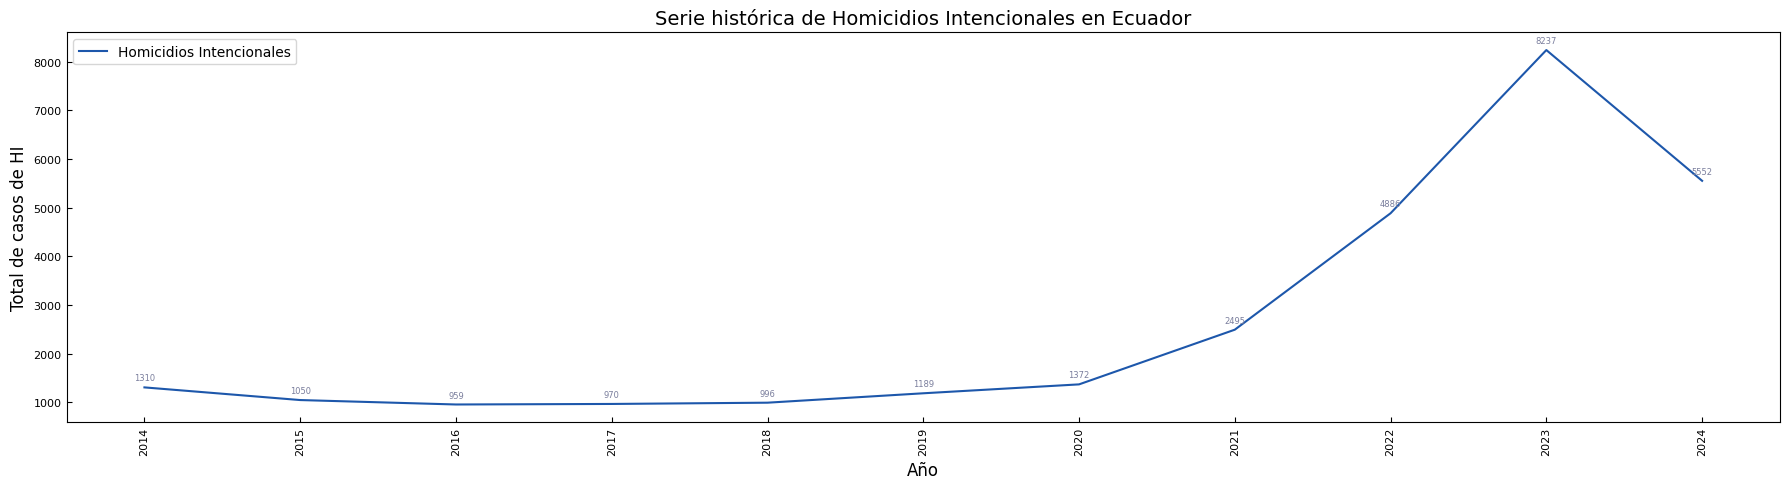

In [8]:
plot_line_graph(
    reporte_anual, 
    x_col="anio_infraccion", 
    y_cols=["total_casos_hi"], 
    title="Serie histórica de Homicidios Intencionales en Ecuador", 
    xlabel="Año", 
    ylabel="Total de casos de HI",
    legend_labels=["Homicidios Intencionales"],
    line_colors=["#1d57ab"],  # Personalizar el color de la línea
    value_label_color="#7a7e9d",  # Personalizar el color de las etiquetas de valores
    value_label_size=6,        # Reducir el tamaño de las etiquetas de valores
    save_path="IMG/total_casos_hi_nacional.png")

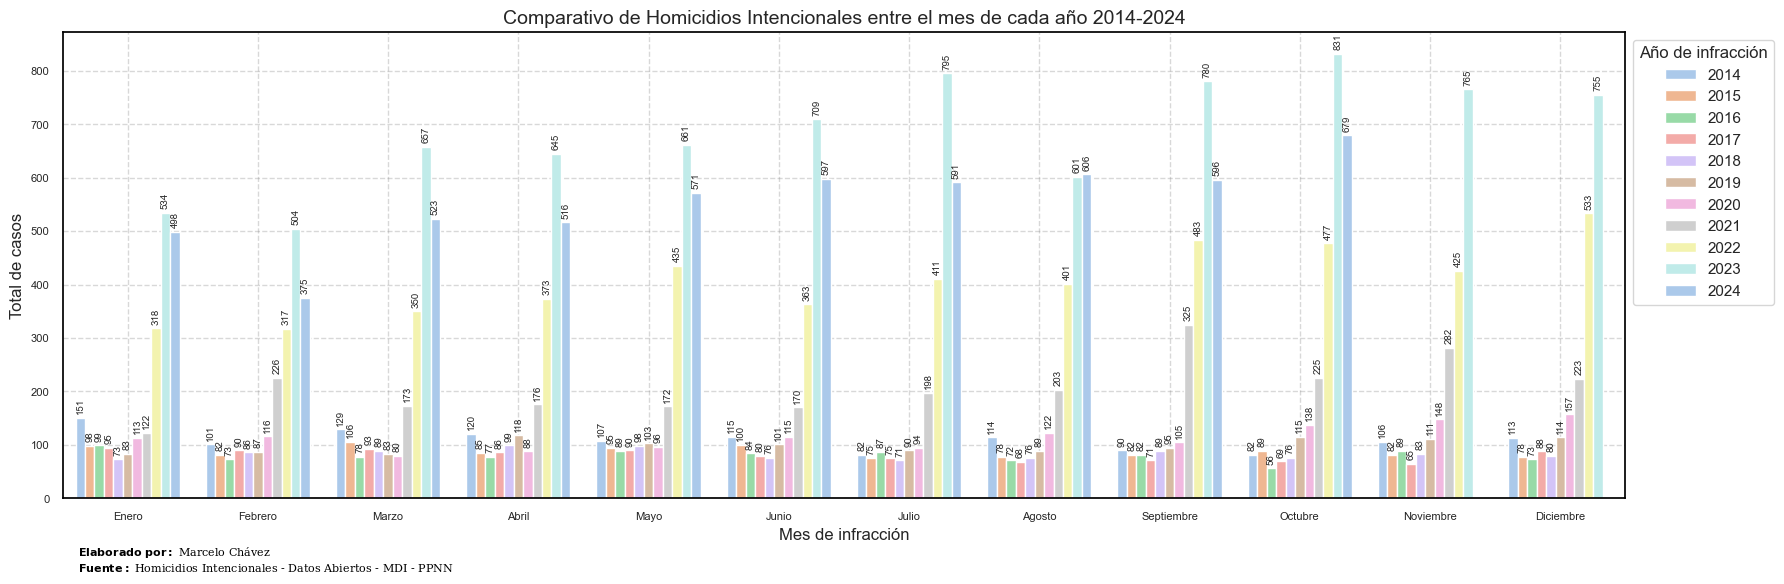

In [21]:
# Configurar estilo
sns.set(style="whitegrid")
# Paleta de colores pastel
pastel_palette = sns.color_palette("pastel")

# Crear el gráfico
plt.figure(figsize=(18, 6))

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    data=reporte_mensual,
    x="nombre_mes_infraccion",
    y="total_casos_hi",
    hue="anio_infraccion",
    palette=pastel_palette,  # Aplicar la paleta pastel
    errorbar=None)

# Mostrar los valores encima de las barras con un tamaño de fuente más pequeño
for container in ax.containers:
    ax.bar_label(container, rotation=90, padding=3, fontsize=7)  # Reducir el tamaño de la fuente

# Configurar el marco del gráfico con color negro
plt.gca().spines['top'].set_color('black')  # Borde superior
plt.gca().spines['right'].set_color('black')  # Borde derecho
plt.gca().spines['left'].set_color('black')  # Borde izquierdo
plt.gca().spines['bottom'].set_color('black')  # Borde inferior

# Estilo del grid con líneas entrecortadas
plt.grid(True, which='both', axis='both', linestyle='--', color='gray', alpha=0.3)

# Etiquetas y título
plt.title("Comparativo de Homicidios Intencionales entre el mes de cada año 2014-2024", fontsize=14)
plt.xlabel("Mes de infracción", fontsize=12)
plt.ylabel("Total de casos", fontsize=12)
plt.xticks(rotation=0, fontsize=8)  # Rotar los nombres de los meses en el eje X
plt.yticks(rotation=0, fontsize=8)  # Rotar los nombres de los meses en el eje Y
plt.legend(title="Año de infracción", loc="upper left", bbox_to_anchor=(1, 1))

# Agregar pie de página (footnote)
footnote_text = (
    r"$\bf{Elaborado\ por:}$ Marcelo Chávez" + "\n" + 
    r"$\bf{Fuente:}$ Homicidios Intencionales - Datos Abiertos - MDI - PPNN"
)

plt.text(
    0.01,  # Coordenada X (cerca del borde izquierdo)
    -0.1,  # Coordenada Y (debajo del gráfico)
    footnote_text,
    ha='left',  # Alineación horizontal a la izquierda
    va='top',   # Alineación vertical en la parte superior
    fontsize=8,  # Tamaño de la fuente
    color='black',  # Color del texto
    transform=plt.gca().transAxes,  # Usar coordenadas relativas al gráfico
    family='serif'  # Establecer fuente serif para una mejor apariencia de negrita
)

# Mostrar el gráfico
plt.tight_layout()
plt.show()